# Rejection Approximate Bayesian Computation (REJ-ABC) for (3) parameter inference of a repressilator

First we define the distance function, in this case Euclidean distance - it's great

In [1]:
import numpy as np
#Distance function HELLO
def euclidean_distance_multiple_trajectories(observed_trajectories, simulated_trajectories):
    num_trajectories = len(observed_trajectories)
    total_distance = 0.0

    for i in range(num_trajectories):
        observed_data = observed_trajectories[i]
        simulated_data = simulated_trajectories[i]

        # Calculate the Euclidean distance between observed and simulated data
        euclidean_distance = np.linalg.norm(observed_data - simulated_data)

        # Accumulate the distances
        total_distance += euclidean_distance

    # Average the distances over all trajectories
    average_distance = total_distance / num_trajectories

    return average_distance

Secondly we specify a smoothing kernel as a function of $\epsilon$ as an alternative to a regular distance threshold cutoff

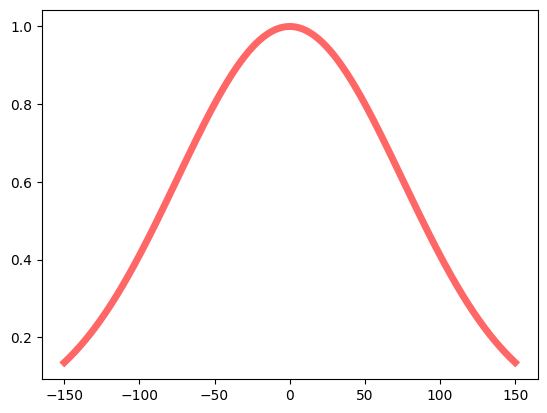

In [2]:
#Visualise the smoothing kernel wrt epsilon
       #We have a 0.135 chance of accepting above the threshold!
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
epsilon = 150
x = np.linspace(-epsilon, epsilon, 1000)
normalising_factor = 1/norm.pdf(0, loc=0, scale = epsilon)
ax.plot(x, norm.pdf(x, loc=0, scale=epsilon/2)*normalising_factor/2,

       'r-', lw=5, alpha=0.6, label='norm pdf')

In [3]:
epsilon = 150 #Results independent of epsilon
norm.pdf(-epsilon, loc=0, scale=epsilon/2)*normalising_factor/2

0.1353352832366127

# Try for three parameters (k1, k2, k3) (use a bigger epsilon $\epsilon = 150$)

In [4]:
# ABC rejection
from scipy.stats import norm
def abc_rejection(true_params, epsilon, num_samples):
    accepted_params = []
    accepted_data = []  # Added to store simulated data for accepted parameters
   
    for _ in range(num_samples):
        # Define prior and sample
        sampled_params = np.random.uniform(low=-3, high=3, size=len(true_params)) #Wide priors
       
        # Generate synthetic data using samples
        sampled_data = solve_ode(sampled_params, t)

        distance = euclidean_distance_multiple_trajectories(true_data, sampled_data)
        normalising_factor = 1/norm.pdf(0, loc=0, scale = epsilon)
        smooth_threshold = norm.pdf(distance, loc=0, scale=epsilon/2)*normalising_factor/2
        rdm_tmp = np.random.uniform(low=0, high=1, size=1)
        if rdm_tmp < smooth_threshold: #If the random number is below the threshold, we accept it
            accepted_params.append(sampled_params)
            accepted_data.append(sampled_data)
   
    return np.array(accepted_params), np.array(accepted_data)



In [5]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2, k3 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** k3 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0, 0  # first set of odes
])

#Define the solver using odeint
def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 1000  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps) #Range of time of simulation
true_data = solve_ode(true_params, t) #True trajectories

epsilon = 150 # Error threshold used in kernel, higher than 2 params
num_samples = 10000  # Number of samples to draw

#Algorithm
accepted_parameters, accepted_data = abc_rejection(true_params, epsilon, num_samples)

Number of Accepted Sets of Parameters: 44

    k1      k2      k3
------  ------  ------
 0.882   0.562  -0.425
 2.625   1.164   2.508
 2.912  -0.55    0.833
-0.617   0.366   0.826
-0.205   0.713   2.465
 0.093   0.39   -0.427
 0.707   0.942  -0.942
-0.804   0.567   1.134
 0.625   2.649   2.561
 1.916   1.519   0.6
 1.915   0.835   0.486
 0.768   2.248  -0.583
 1.942   0.998   1.262
 1.06   -0.133  -0.526
 1.632  -0.362   0.889
 1.269   0.78    2.562
 2.187   2.257   2.75
 1.777   0.532   0.619
 1.782   0.354   1.736
 1.155   1.115   2.147
 1.012  -0.152   1.197
 0.292   0.445   1.926
 1.745   0.264   1.409
-0.067  -0.15   -0.049
 2.116   2.855   2.01
-0.12    0.094   0.013
 2.76    2.699   2.344
 2.694   0.37    0.723
 2.382   2.719   1.434
 1.536   1.98    0.98
 0.433   1.47    0.995
 2.26    2.407   0.802
 1.226   1.062   2.992
 2.602   2.228   0.411
 0.45    2.509   2.599
 0.748   2.713   1.369
-0.109   0.938   1.907
 1.87    0.437   0.845
 0.558   1.539   0.945
-0.164   0.626   1.

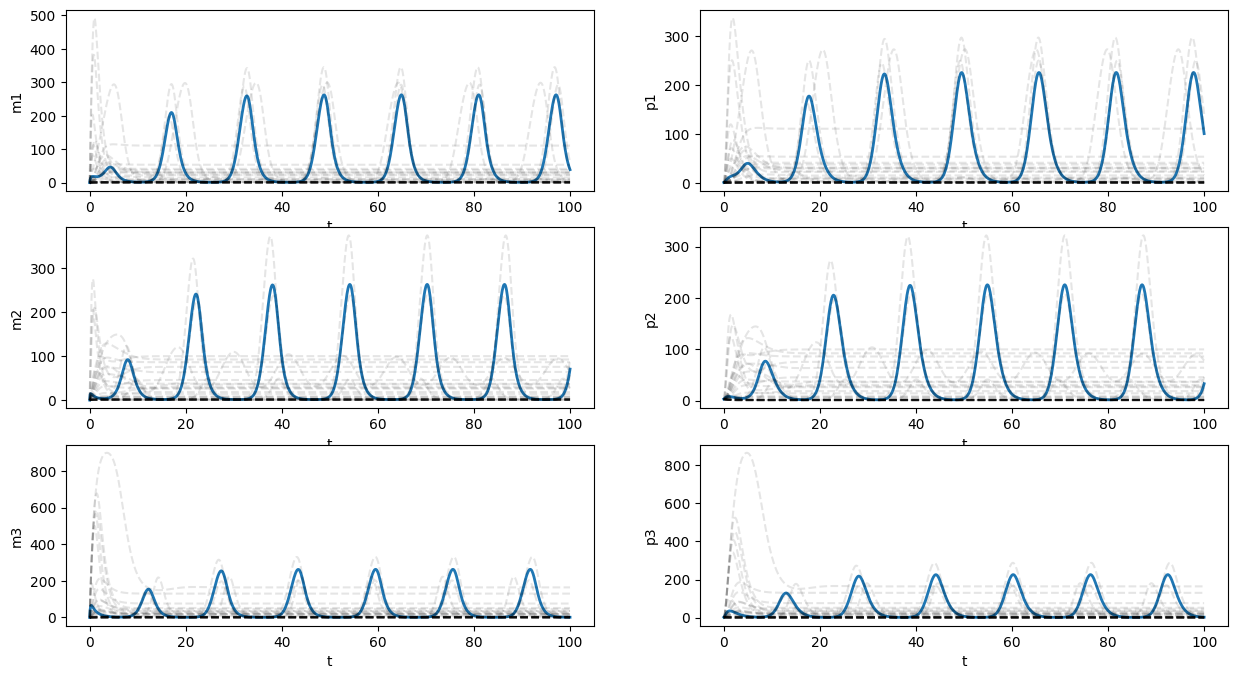

In [6]:
#Print n of accepted params and trajectories
print(f"Number of Accepted Sets of Parameters: {len(accepted_parameters)}\n")

headers = ['k1', 'k2', 'k3']
table_data = [headers] + [[round(p, 3) for p in params] for params in accepted_parameters]
table=tabulate(table_data, headers="firstrow")
print(table)
    
# Plot real trajectories and also accepted trajectories, they overlap
fig, axs = plt.subplots(3, 2, figsize=(15, 8))
axs = axs.flatten()

variable_labels = ['m1', 'p1', 'm2', 'p2', 'm3', 'p3']

for i in range(6):
    axs[i].plot(t, true_data[:, i], label='True Data', linewidth=2)
    axs[i].set_xlabel('t')
    axs[i].set_ylabel(variable_labels[i])
    
    for simulated_data in accepted_data:
        axs[i].plot(t, simulated_data[:, i], 'k--', alpha=0.1)

plt.show()

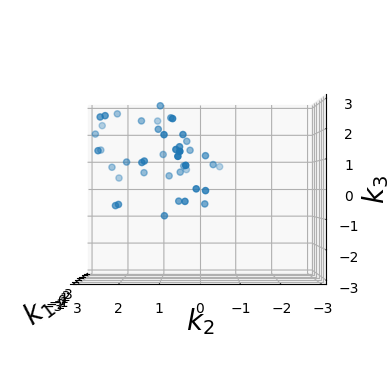

In [7]:
k1_accept = []
k2_accept = []
k3_accept = []
for i in range(len(accepted_parameters)):
    k1_accept.append(accepted_parameters[i][0])
    k2_accept.append(accepted_parameters[i][1])
    k3_accept.append(accepted_parameters[i][2])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(k1_accept, k2_accept, k3_accept) 
ax.set_xlabel(r"$k_{1}$", fontsize = 20) 
ax.set_ylabel(r"$k_{2}$", fontsize = 20) 
ax.set_zlabel(r"$k_{3}$", fontsize = 20) 
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
ax.set_zlim([-3, 3])

ax.view_init(0, 180)



TypeError: <seaborn.axisgrid.PairGrid object at 0x7f043145d710> is not a callable object

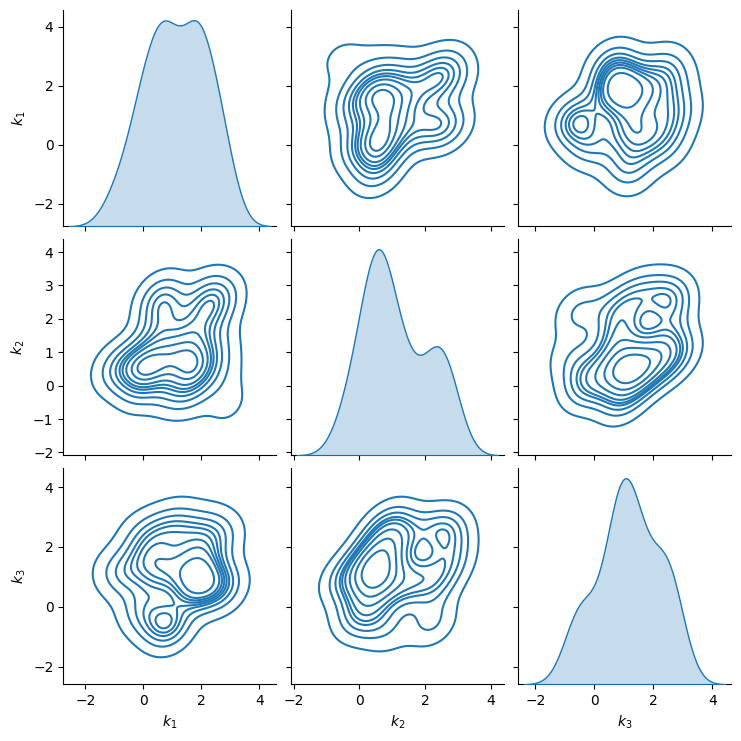

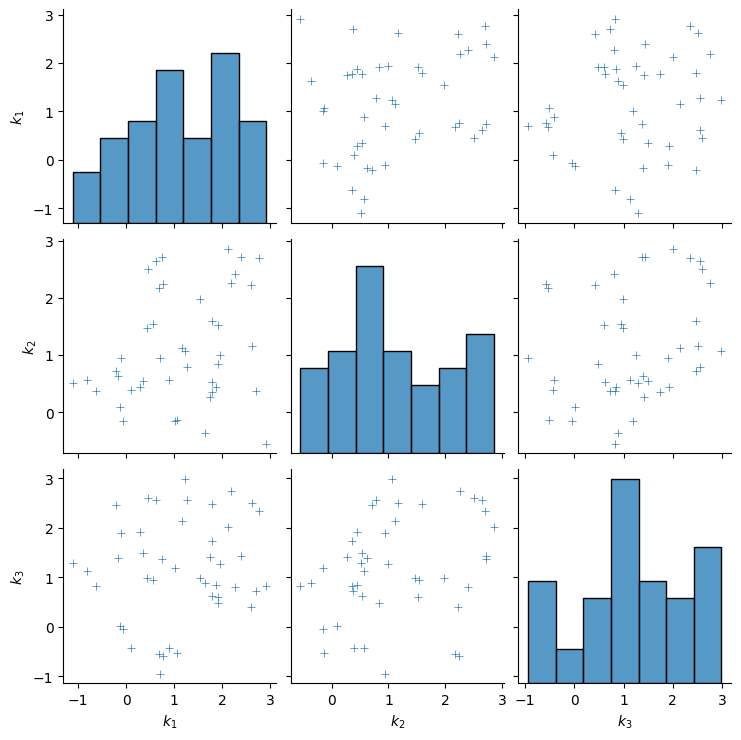

In [9]:
import seaborn as sns
import pandas as pd
plot_k = pd.DataFrame(data=np.array([k1_accept, k2_accept, k3_accept]), index=(r"$k_{1}$", r"$k_{2}$", r"$k_{3}$"))
plot_k_t = pd.DataFrame.transpose(plot_k)
g = sns.pairplot(plot_k_t, kind="kde")
g.map_lower(sns.pairplot(plot_k_t, plot_kws=dict(marker="+")))

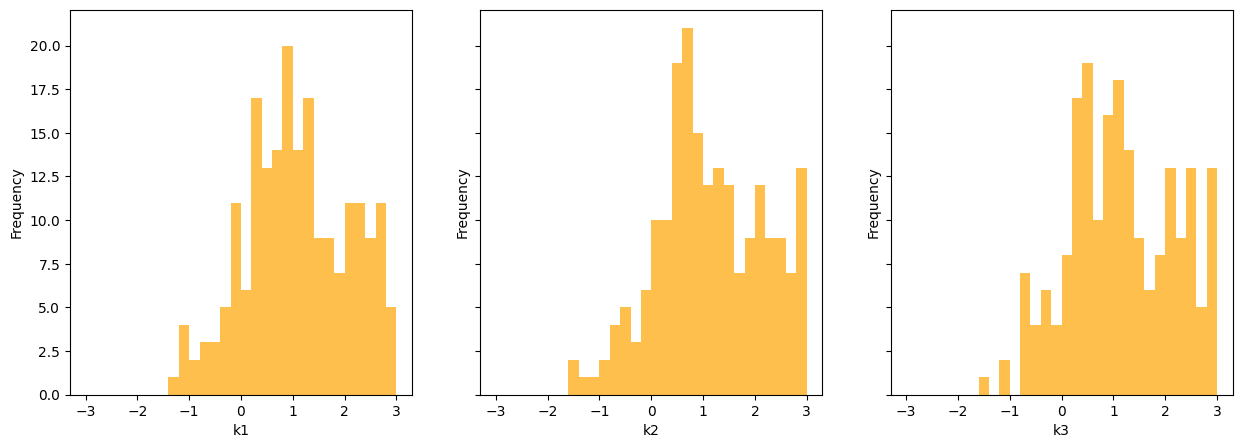

In [ ]:
# Plot histograms
fig, axs = plt.subplots(1, len(true_params), figsize=(15, 5), sharey=True)
all_accepted_parameters_array = np.array(accepted_parameters)
for i, param_name in enumerate(headers):
    axs[i].hist(all_accepted_parameters_array[:, i], range=[-3, 3], bins=30,alpha=0.7, color='orange')
    axs[i].set_xlabel(param_name)
    axs[i].set_ylabel('Frequency')